In [1]:
cd ../TileEM/

/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ../TileEM/stored_ptk_run

/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run


In [ ]:
ls

In [ ]:
objid=1
niter=3
tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
pInT = pkl.load(open("pInT_lst_obj{0}_iter{1}.pkl".format(objid,niter)))
pNotInT = pkl.load(open("pNotInT_lst_obj{0}_iter{1}.pkl".format(objid,niter)))
Qj = pkl.load(open("Qj_obj{0}_iter{1}.pkl".format(objid,niter)))
#Tstar
Tstar = pkl.load(open("iter_0/tid_list.pkl"))
Tstar2 = pkl.load(open("iter_9/tid_list.pkl"))

### Looking at how different threshold values do for different T* construction thresholds 

In [5]:
objid =
ls 10worker_rand0/obj1/thresh-10/iter_0/

10worker_rand0/  15worker_rand3/  5worker_rand1/  nohup.out
10worker_rand1/  15worker_rand4/  5worker_rand2/  runIndicatorMat.py
10worker_rand2/  15worker_rand5/  5worker_rand3/  sample20.out
10worker_rand3/  20worker_rand0/  5worker_rand4/  sample25_0.out
10worker_rand4/  20worker_rand1/  5worker_rand5/  sampling2.sh
10worker_rand5/  20worker_rand2/  5worker_rand6/  sampling.sh
10worker_rand6/  20worker_rand3/  5worker_rand7/  TileEM_plot_toolbox.py
10worker_rand7/  25worker_rand0/  5worker_rand8/  TileEM_plot_toolbox.pyc
15worker_rand0/  25worker_rand1/  5worker_rand9/
15worker_rand1/  30worker_rand0/  main.py
15worker_rand2/  5worker_rand0/   main.pyc


In [ ]:
precisions = []
recalls = []
for sample_path in glob.glob('{}/*/'.format(indir)):
    print '======================================================'
    sample_name = sample_path.split('/')[-2]
    print 'Processing sample ', sample_name
    # if sample_name != '5worker_rand0':
    #     continue
    # for objid in objects:
    for objid in range(1, 48):
        # if objid != 18:
        #     continue
        print 'Doing object ', objid
        print '-----------------------------------------------------'
        #tiles = pickle.load(open('{}vtiles{}.pkl'.format(sample_path, objid)))
        #indMat = pickle.load(open('{}indMat{}.pkl'.format(sample_path, objid)))
        
        #do stuff
        precisions.append(precision(CORE, GTBB))
        recalls.append(recall(CORE, GTBB))
print 'Precision stats:'
print 'Mean: {}, median: {}, std: {}, min: {}, max: {}'.format(
    np.mean(precisions), np.median(precisions), np.std(precisions), min(precisions), max(precisions))
print 'Recall stats:'
print 'Mean: {}, median: {}, std: {}, min: {}, max: {}'.format(
    np.mean(recalls), np.median(recalls), np.std(recalls), min(recalls), max(recalls))

In [143]:
# Compute PR from all baselines + TileEM
import pickle as pkl 
from TileEM_plot_toolbox import *
from qualityBaseline import *
from glob import glob
from collections import OrderedDict
from bad_vtiles import * 
df = pd.read_csv("../computed_my_COCO_BBvals.csv",index_col=0)
worker_Nbatches={5:10,10:8,15:6,20:4,25:2,30:1}
base_dir= "stored_ptk_run"
sampleN_lst=worker_Nbatches.keys()
#mode="aggregate_sample_table"
mode="recompute_sample_batch_table"

if mode =="recompute_sample_batch_table":
	# Compute and save a  PR_tbl_all.csv into each sample_batch folder 
	for Nworker in sampleN_lst:
		for batch_num in range(worker_Nbatches[Nworker]):
			dir_name = "{0}worker_rand{1}".format(Nworker,batch_num)
			
			print "Working on :", dir_name
			os.chdir(base_dir+"/"+dir_name)
			 
			# Creating 2 empty precision recall table containing P,R for each metric used 
			cols = [u'Num Points',u'Area Ratio',u'Jaccard [Self]', u'Precision [Self]', u'Recall [Self]']

			PR_tbl = pd.DataFrame()#index=object_lst)#,columns=cols)
			PR_tbl["object_id"]=object_lst
			# Summarization-Based Method
			df.ix[df["Precision [Self]"]>1,"Precision [Self]"]=1
			df.ix[df["Recall [Self]"]>1,"Recall [Self]"]=1
			df = df[~(df["worker_id"].isin([1,2,3]))] #Filter our ground truth workers
			for attr in cols:
				tbl=[]
				for objid in object_lst:
					workers=pkl.load(open("worker{}.pkl".format(objid)))
					filtered_df = df[(df["worker_id"].isin(workers))&(df["object_id"]==objid)] #only look at summarization scores of sampled workers
					best_worker_BB = filtered_df[filtered_df[attr]==filtered_df[attr].max()]
					if objid not in [35,41]:
					    tbl.append([objid,best_worker_BB["Precision [Self]"].values[0],best_worker_BB["Recall [Self]"].values[0]])
					else:
					    tbl.append([objid,-1,-1])
				tmp_PR_tbl = pd.DataFrame(tbl,columns=["object_id","Precision","Recall"])
				PR_tbl["P [{}]".format(attr)]=tmp_PR_tbl["Precision"]
				PR_tbl["R [{}]".format(attr)]=tmp_PR_tbl["Recall"]
			# Vision based methods
			print os.getcwd()
			visionPR = pd.read_csv("../../Vision-stuff/VisionGTComparisons/{}/best_Area_Ratio_BBs/box/prec50/PR.csv".format(dir_name))
			PR_tbl["P [Vision Best Area Ratio 50%]"] = visionPR["precision"] 
			PR_tbl["R [Vision Best Area Ratio 50%]"] = visionPR["recall"]
			
			visionPR = pd.read_csv("../../Vision-stuff/VisionGTComparisons/{}/best_Num_Points_BBs/box/prec50/PR.csv".format(dir_name))
			PR_tbl["P [Vision Best Num Points 50%]"] = visionPR["precision"]
                        PR_tbl["R [Vision Best Num Points 50%]"] = visionPR["recall"]	 
            
			for threshold in [10,50,90]:
				visionPR = pd.read_csv("../../../PR{}.csv".format(threshold))
				PR_tbl["P [Vision GT {}%]".format(threshold)] = visionPR["precision"]
				PR_tbl["R [Vision GT {}%]".format(threshold)] = visionPR["recall"]
			#MVT, Tile
			tbl=[]
			for fname in glob("Tstar_idx_obj*.pkl"):
				objid=int(fname.split("_")[-1].split(".")[0][3:])
				tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
				#Tile EM
				Tstar_lst = pkl.load(open("Tstar_idx_obj{}.pkl".format(objid)))
				TileEMP,TileEMR = compute_PR(objid,np.array(Tstar_lst[-1]),tiles)
				# Majority Vote 
				PMVT,RMVT = majority_vote(objid,heuristic="50%")
				PMVTtopk,RMVTtopk = majority_vote(objid,heuristic="topk")
				PMVTtopP,RMVTtopP = majority_vote(objid,heuristic="topPercentile")
				tbl.append([objid,TileEMP,TileEMR,PMVT,RMVT,PMVTtopk,RMVTtopk,PMVTtopP,RMVTtopP])
			Tile_df = pd.DataFrame(tbl,columns=["object_id","P [TileEM]","R [TileEM]","P [MVT]","R [MVT]","P [MVTtop10]","R [MVTtop10]","P [MVTtop95%]","R [MVTtop95%]"])
			PR_tbl_all = PR_tbl.merge(Tile_df,on="object_id")
			#Save to file in that folder 
			PR_tbl_all.to_csv("PR_tbl_all.csv")
			os.chdir("../..")
elif mode =="aggregate_sample_table" :
    sampleN_lst=sorted(worker_Nbatches.keys())

    for Nworker in sampleN_lst:
        print "Working on worker = ",Nworker
        batch_all_data=[]
        for batch_num in range(worker_Nbatches[Nworker]):
            dir_name = "sample/{0}worker_rand{1}".format(Nworker,batch_num)
            batch_i_data=pd.read_csv(dir_name+"/PR_tbl_all.csv",index_col=0)
            #Drop the object rows where the objects have bad vtiles to begin with 
            bad_vtile_objs = list(problematic[(problematic["Nworker"]==Nworker)&(problematic["batch_num"]==batch_num)].objid)
	    bad_vtile_objs.extend([35,41]) # Discard ambiguous objects 
            batch_i_data=batch_i_data.drop(bad_vtile_objs,errors='ignore')
            #batch_i_data[~batch_i_data["object_id"].isin(bad_vtile_objs)]
            # First set the object_id column the index, then reindex based on this index to correspond to object lst
            # This fills in a row of NaN for the missing data objects, so it normalizes the shape of our data table 
            batch_i_data = batch_i_data.set_index('object_id').reindex(object_lst,fill_value =0)
             # Add a row of non-nan count for averaging 
            nan_rowidx= list(batch_i_data[batch_i_data["P [Num Points]"]==0].index)
            non_nan_count = np.ones_like(object_lst)
            #non_nan_count = np.ones(47)
	    for row in nan_rowidx: non_nan_count[row-1]=0
            batch_i_data["non_nan_count"]=non_nan_count
            if batch_num==0:
                batch_all_data=batch_i_data
            else:
                batch_all_data+=batch_i_data
        # Renaming data columns
        df = df.rename(index=str,columns={'P [Jaccard [Self]]':'P [GT Jaccard]','R [Jaccard [Self]]':'R [GT Jaccard]',\
                             'P [Precision [Self]]':'P [GT Precision]','R [Precision [Self]]':'R [GT Precision]',\
                             'P [Recall [Self]]':'P [GT Recall]','R [Recall [Self]]':'R [GT Recall]',\
                            })
        try:
            batch_all_data=batch_all_data[batch_all_data.keys()[:-1]].divide(batch_all_data["non_nan_count"],axis=0)
            batch_all_data[batch_all_data>1]=1
            batch_all_data[batch_all_data<0]=0
	    print "Created sample{}_PR.csv".format(Nworker)
            batch_all_data.to_csv("sample{}_PR.csv".format(Nworker))
        except(ZeroDivisionError):
            print "No data for worker=",Nworker 




Working on : 5worker_rand0
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand0
Working on : 5worker_rand1
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand1
Working on : 5worker_rand2
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand2
Working on : 5worker_rand3
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand3
Working on : 5worker_rand4
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand4
Working on : 5worker_rand5
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand5
Working on : 5worker_rand6
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand6
Working on : 5worker_rand7
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand7
Working on : 5worker_rand8
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand8
Working on : 5worker_rand9
/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/5worker_rand9
Working on : 10worker_rand0
/home/jlee78

In [20]:
cd analysis/TileEM/

/home/jlee782/crowd-seg/analysis/TileEM


In [77]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [79]:
def precision_from_list(test_list, base_poly):
    int_area = 0.0
    test_poly_area = 0.0
    for test_poly in test_list:
        int_area += intersection_area(test_poly, base_poly)
        test_poly_area += test_poly.area
    return (int_area / test_poly_area) if (test_poly_area != 0) else 0
def recall_from_list(test_list, base_poly):
    int_area = 0.0
    for test_poly in test_list:
        int_area += intersection_area(test_poly, base_poly)
    return (int_area / base_poly.area) if (base_poly.area != 0) else 0

In [123]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [81]:
from calc_Tstar import *

In [147]:
base_dir= "stored_ptk_run"
# Compute and save a  PR_tbl_all.csv into each sample_batch folder 
for Nworker in [10]:#sampleN_lst:
    for batch_num in range(worker_Nbatches[Nworker]):

#         dir_name = "{0}worker_rand{1}".format(Nworker,batch_num)
# dir_name ="stored_ptk_run/15"

        print "Working on :", dir_name
        os.chdir(base_dir+"/"+dir_name)

        # Creating 2 empty precision recall table containing P,R for each metric used 
        cols = [u'Num Points',u'Area Ratio',u'Jaccard [Self]', u'Precision [Self]', u'Recall [Self]']

        PR_tbl = pd.DataFrame()#index=object_lst)#,columns=cols)
        PR_tbl["object_id"]=object_lst
        # Summarization-Based Method
        df.ix[df["Precision [Self]"]>1,"Precision [Self]"]=1
        df.ix[df["Recall [Self]"]>1,"Recall [Self]"]=1
        df = df[~(df["worker_id"].isin([1,2,3]))] #Filter our ground truth workers
        for attr in cols:
            tbl=[]
            for objid in object_lst:
                workers=pkl.load(open("worker{}.pkl".format(objid)))
                filtered_df = df[(df["worker_id"].isin(workers))&(df["object_id"]==objid)] #only look at summarization scores of sampled workers
                best_worker_BB = filtered_df[filtered_df[attr]==filtered_df[attr].max()]
                if objid not in [35,41]:
                    tbl.append([objid,best_worker_BB["Precision [Self]"].values[0],best_worker_BB["Recall [Self]"].values[0]])
                else:
                    tbl.append([objid,-1,-1])
            tmp_PR_tbl = pd.DataFrame(tbl,columns=["object_id","Precision","Recall"])
            PR_tbl["P [{}]".format(attr)]=tmp_PR_tbl["Precision"]
            PR_tbl["R [{}]".format(attr)]=tmp_PR_tbl["Recall"]
        # Vision based methods
        visionPR = pd.read_csv("../../Vision-stuff/VisionGTComparisons/{}/best_Area_Ratio_BBs/box/prec50/PR.csv".format(dir_name))
        PR_tbl["P [Vision Best Area Ratio 50%]"] = visionPR["precision"] 
        PR_tbl["R [Vision Best Area Ratio 50%]"] = visionPR["recall"]

        visionPR = pd.read_csv("../../Vision-stuff/VisionGTComparisons/{}/best_Num_Points_BBs/box/prec50/PR.csv".format(dir_name))
        PR_tbl["P [Vision Best Num Points 50%]"] = visionPR["precision"]
        PR_tbl["R [Vision Best Num Points 50%]"] = visionPR["recall"]

        for threshold in [10,50,90]:
            visionPR = pd.read_csv("../../../PR{}.csv".format(threshold))
            PR_tbl["P [Vision GT {}%]".format(threshold)] = visionPR["precision"]
            PR_tbl["R [Vision GT {}%]".format(threshold)] = visionPR["recall"]
        #MVT, Tile
        tbl=[]
        col_lst = []
        for i,fname in enumerate(glob.glob("obj*")):
            objid=int(fname[3:])
            BBG =get_gt(objid)
            tmp_tbl=[objid]
            if i==0: col_lst = ["object_id"]
            tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
            #Tile EM
            thresh=0
            for thresh in [-20,-10,0,10,20]:
                Tstar_idx_lst = pkl.load(open("obj{0}/thresh{1}/iter_5/tid_list.pkl".format(objid,thresh)))
                #TileEMP,TileEMR = compute_PR(objid,np.array(Tstar_lst),tiles)
                Tstar_lst = [tiles[tidx] for tidx in Tstar_idx_lst]
#                 print sorted(Tstar_idx_lst)
                print len(set(Tstar_idx_lst))==len(Tstar_idx_lst)
#                     TileEMP = precision_from_list(Tstar_lst,BBG)
#                     TileEMR = recall_from_list(Tstar_lst,BBG)
#                     tmp_tbl.extend([TileEMP,TileEMR])
#                     if i==0: col_lst.extend(["P [TileEM thres={}]".format(thresh),"R [TileEM thres={}]".format(thresh)])
#                 # Majority Vote 
#                 PMVT,RMVT = majority_vote(objid,heuristic="50%")
#                 PMVTtopk,RMVTtopk = majority_vote(objid,heuristic="topk")
#                 PMVTtopP,RMVTtopP = majority_vote(objid,heuristic="topPercentile")
#                 tmp_tbl.extend([PMVT,RMVT,PMVTtopk,RMVTtopk,PMVTtopP,RMVTtopP])
#                 if i==0: col_lst.extend(["P [MVT]","R [MVT]","P [MVTtop10]","R [MVTtop10]","P [MVTtop95%]","R [MVTtop95%]"])
#                 tbl.append(tmp_tbl) #[objid,TileEMP,TileEMR,PMVT,RMVT,PMVTtopk,RMVTtopk,PMVTtopP,RMVTtopP]
#             Tile_df = pd.DataFrame(tbl,columns=col_lst)
#             PR_tbl_all = PR_tbl.merge(Tile_df,on="object_id")
#             #Save to file in that folder 
#             PR_tbl_all.to_csv("PR_tbl_all.csv")
        os.chdir("../..")

Working on : 30worker_rand0


OSError: [Errno 2] No such file or directory: 'stored_ptk_run/30worker_rand0'

In [110]:
PR_tbl_all.filter(regex="TileEM").mean()

P [TileEM thres=-20]    0.852116
R [TileEM thres=-20]    1.761445
P [TileEM thres=-10]    0.852116
R [TileEM thres=-10]    1.761445
P [TileEM thres=0]      0.852116
R [TileEM thres=0]      1.761445
P [TileEM thres=10]     0.903219
R [TileEM thres=10]     0.729380
P [TileEM thres=20]     0.903219
R [TileEM thres=20]     0.729380
dtype: float64

In [117]:
PR_tbl_all.filter(regex="TileEM")

,P [TileEM thres=-20],R [TileEM thres=-20],P [TileEM thres=-10],R [TileEM thres=-10],P [TileEM thres=0],R [TileEM thres=0],P [TileEM thres=10],R [TileEM thres=10],P [TileEM thres=20],R [TileEM thres=20]
0,0.984424,1.863175,0.984424,1.863175,0.984424,1.863175,0.999647,0.893541,0.999647,0.893541
1,0.922590,1.814825,0.922590,1.814825,0.922590,1.814825,0.999999,0.800375,0.999999,0.800375
2,0.929821,1.845695,0.929821,1.845695,0.929821,1.845695,0.983845,0.828099,0.983845,0.828099
3,0.888035,1.892515,0.888035,1.892515,0.888035,1.892515,0.975706,0.709124,0.975706,0.709124
4,0.964414,1.591697,0.964414,1.591697,0.964414,1.591697,0.985304,0.708241,0.985304,0.708241
5,0.879085,1.558597,0.879085,1.558597,0.879085,1.558597,0.986071,0.600363,0.986071,0.600363
6,0.855685,1.014910,0.855685,1.014910,0.855685,1.014910,0.962048,0.404397,0.962048,0.404397
7,0.894080,1.421868,0.894080,1.421868,0.894080,1.421868,1.000000,0.478380,1.000000,0.478380
8,0.973972,1.854296,0.973972,1.854296,0.973972,1.854296,0.968928,0.881126,0.968928,0.881126
9,0.974162,1.939019,0.974162,1.939019,0.974162,1.939019,0.992178,0.926828,0.992178,0.926828


In [74]:
Tile_df = pd.DataFrame(tbl,columns=col_lst)

In [75]:
Tile_df

,object_id,P [TileEM thres=-20],R [TileEM thres=-20],P [TileEM thres=-10],R [TileEM thres=-10],P [TileEM thres=0],R [TileEM thres=0],P [TileEM thres=10],R [TileEM thres=10],P [TileEM thres=20],R [TileEM thres=20],P [MVT],R [MVT],P [MVTtop10],R [MVTtop10],P [MVTtop95%],R [MVTtop95%]
0,1,0.989344,0.945069,0.989344,0.945069,0.989344,0.945069,0.999647,0.893541,0.999647,0.893541,0.912580,0.029576,0.999607,0.901618,0.999642,0.894924
1,11,0.854587,0.770401,0.854587,0.770401,0.854587,0.770401,0.966159,0.614458,0.966159,0.614458,0.892763,0.845811,0.950832,0.655145,0.965820,0.631400
2,31,0.961442,0.964704,0.961442,0.964704,0.961442,0.964704,0.984450,0.946145,0.984450,0.946145,0.975630,0.962076,0.981794,0.950244,0.983077,0.946169
3,32,0.741943,0.990164,0.741943,0.990164,0.741943,0.990164,0.995434,0.902217,0.995434,0.902217,0.380962,0.014154,0.985700,0.933917,0.985715,0.932940
4,33,0.981503,0.972586,0.981503,0.972586,0.981503,0.972586,0.992273,0.970968,0.992273,0.970968,0.616834,0.021031,0.991504,0.973428,0.991942,0.971773
5,16,0.934182,0.991781,0.934182,0.991781,0.934182,0.991781,0.988747,0.924964,0.988747,0.924964,0.460998,0.064833,0.938327,0.963788,0.420948,0.038396
6,34,0.982087,0.932587,0.982087,0.932587,0.982087,0.932587,0.997094,0.814299,0.997094,0.814299,0.992136,0.923929,0.996822,0.824704,0.997094,0.814299
7,19,0.992792,0.776913,0.992792,0.776913,0.992792,0.776913,0.998224,0.721965,0.998224,0.721965,0.294887,0.005613,0.984346,0.833804,0.998224,0.721965
8,20,0.931699,0.806322,0.931699,0.806322,0.931699,0.806322,0.826862,0.797657,0.826862,0.797657,0.994740,0.725634,0.994485,0.691988,0.994630,0.633380
9,22,0.747190,0.998505,0.747190,0.998505,0.747190,0.998505,0.896593,0.742436,0.896593,0.742436,0.853830,0.985590,0.947324,0.855575,0.986783,0.735262


In [149]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [238]:
ls -ltr stored_ptk_run/10worker_rand0/PR_tbl_all.csv

-rw-r-----. 1 jlee782 jlee782 25460 May  2 21:54 stored_ptk_run/10worker_rand0/PR_tbl_all.csv


In [239]:
PR_tbl = pd.read_csv("stored_ptk_run/10worker_rand0/PR_tbl_all.csv",index_col=0)

In [241]:
PR_tbl[PR_tbl["object_id"]==1].filter(regex="TileEM").mean()

P [TileEM thres=-20]    0.988033
R [TileEM thres=-20]    0.961377
P [TileEM thres=-10]    0.970801
R [TileEM thres=-10]    0.969634
P [TileEM thres=0]      0.992894
R [TileEM thres=0]      0.956808
P [TileEM thres=10]     0.999647
R [TileEM thres=10]     0.893541
P [TileEM thres=20]     0.995613
R [TileEM thres=20]     0.952810
dtype: float64

In [242]:
cd stored_ptk_run/10worker_rand0/

/home/jlee782/crowd-seg/analysis/TileEM/stored_ptk_run/10worker_rand0


In [253]:
objid=1
BBG =get_gt(objid)
tmp_tbl=[]
if i==0: col_lst = ["object_id"]
tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
#Tile EM
for thresh in [-40,-20,0,20,40]:
    Tstar_idx_lst = list(set(pkl.load(open("obj{0}/thresh{1}/iter_5/tid_list.pkl".format(objid,thresh)))))
    #TileEMP,TileEMR = compute_PR(objid,np.array(Tstar_lst),tiles)
    Tstar_lst = [tiles[tidx] for tidx in Tstar_idx_lst]
    TileEMP = precision_from_list(Tstar_lst,BBG)
    TileEMR = recall_from_list(Tstar_lst,BBG)
    tmp_tbl.append([thresh,TileEMP,TileEMR])

TopologyException: found non-noded intersection between LINESTRING (261.154 324.692, 262.308 327.385) and LINESTRING (261.987 326.636, 262.898 324.085) at 261.98701298701297 326.63636363636363
TopologyException: found non-noded intersection between LINESTRING (261.154 324.692, 262.308 327.385) and LINESTRING (261.987 326.636, 262.898 324.085) at 261.98701298701297 326.63636363636363
TopologyException: found non-noded intersection between LINESTRING (261.154 324.692, 262.308 327.385) and LINESTRING (261.987 326.636, 262.898 324.085) at 261.98701298701297 326.63636363636363
TopologyException: found non-noded intersection between LINESTRING (261.154 324.692, 262.308 327.385) and LINESTRING (261.987 326.636, 262.898 324.085) at 261.98701298701297 326.63636363636363


In [254]:
pd.DataFrame(tmp_tbl)

,0,1,2
0,-40,0.985714,0.964572
1,-20,0.988033,0.961377
2,0,0.992894,0.956808
3,20,0.995613,0.952810
4,40,0.998082,0.941893


In [245]:
TileEMP,TileEMR

(0.9980819002840412, 0.9418925375389331)

In [159]:
PR_tbl = pd.read_csv("stored_ptk_run/10worker_rand1/PR_tbl_all.csv",index_col=0)
PR_tbl.filter(regex="TileEM").mean()

P [TileEM thres=-20]    0.764767
R [TileEM thres=-20]    0.979251
P [TileEM thres=-10]    0.764767
R [TileEM thres=-10]    0.979251
P [TileEM thres=0]      0.764767
R [TileEM thres=0]      0.979251
P [TileEM thres=10]     0.887738
R [TileEM thres=10]     0.693422
P [TileEM thres=20]     0.887738
R [TileEM thres=20]     0.693422
dtype: float64

In [223]:
tid1 = pkl.load(open("stored_ptk_run/10worker_rand0/obj1/thresh0/iter_5/tid_list.pkl"))

In [224]:
sum(tid1)

46203

In [225]:
tid2 = list(set(pkl.load(open("stored_ptk_run/10worker_rand0/obj1/thresh-20/iter_5/tid_list.pkl"))))

In [226]:
sum(tid2)

55173

In [227]:
tid3 = list(set(pkl.load(open("stored_ptk_run/10worker_rand0/obj1/thresh20/iter_5/tid_list.pkl"))))

In [228]:
sum(tid3)

34492

In [218]:
vtile = pkl.load(open("stored_ptk_run/15worker_rand0/vtiles5.pkl"))

In [219]:
len(vtile)

460

In [220]:
len(tid2)

458

In [202]:
tid2==tid1

False

In [196]:
tid3 = list(set(pkl.load(open("stored_ptk_run/15worker_rand0/obj5/thresh10/iter_5/tid_list.pkl"))))

In [197]:
tid2==tid3

False

In [198]:
tid3

[383]

In [199]:
len(tid3)

1

In [203]:
pInT= pkl.load(open("stored_ptk_run/15worker_rand0/pInT_lst_obj5_iter5.pkl"))
pNotInT= pkl.load(open("stored_ptk_run/15worker_rand0/pNotInT_lst_obj5_iter5.pkl"))

In [204]:
pNotInT==pInT

False

In [205]:
len(pNotInT)==len(pInT)

True

In [212]:
mean(pInT)

-10.775669743554216

In [211]:
mean(pNotInT)

-11.313972366307121

In [221]:
thres=0
pInT=np.array(pInT)
pNotInT=np.array(pNotInT)
len(np.where(pInT>=thresh+ pNotInT)[0])

0

# Checking duplicates 

In [133]:
img_name = img_info[img_info.id==int(object_tbl[object_tbl.id==objid]["image_id"])]["filename"].iloc[0]
fname = "../../web-app/app/static/"+img_name+".png"
img=mpimg.imread(fname)
width,height = get_size(fname)

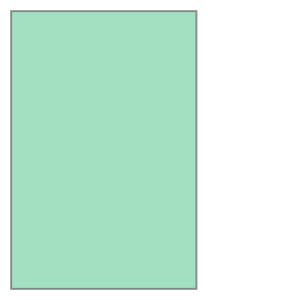

In [142]:
Polygon(((0,0),(0,height),(width,height),(width,0)))

In [114]:
val = []
for objid in object_lst:
    BBG =get_gt(objid)
    tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
    val.append(recall_from_list(tiles,BBG))

TopologyException: found non-noded intersection between LINESTRING (320.6 149.8, 320.25 149.875) and LINESTRING (320.015 149.925, 320.6 149.8) at 320.33744276244778 149.85626226518977
TopologyException: found non-noded intersection between LINESTRING (320.6 149.8, 320.25 149.875) and LINESTRING (320.015 149.925, 320.6 149.8) at 320.33744276244778 149.85626226518977
TopologyException: found non-noded intersection between LINESTRING (229 318, 213.091 321.182) and LINESTRING (219 320, 222 320) at 219 320
TopologyException: found non-noded intersection between LINESTRING (229 318, 213.091 321.182) and LINESTRING (219 320, 222 320) at 219 320
TopologyException: found non-noded intersection between LINESTRING (402.292 242.449, 396.7 238.1) and LINESTRING (396.7 238.1, 404.086 243.845) at 399.8232313056954 240.52917990442975
TopologyException: found non-noded intersection between LINESTRING (402.292 242.449, 396.7 238.1) and LINESTRING (396.7 238.1, 404.086 243.845) at 399.8232313056954 240.5

TopologyException: found non-noded intersection between LINESTRING (222.604 397.097, 224 399) and LINESTRING (223.042 397.38, 222.789 397.349) at 222.7889908256881 397.348623853211
TopologyException: found non-noded intersection between LINESTRING (222.604 397.097, 224 399) and LINESTRING (223.042 397.38, 222.789 397.349) at 222.7889908256881 397.348623853211
TopologyException: found non-noded intersection between LINESTRING (183.459 342.144, 183.353 341.647) and LINESTRING (187.2 337.8, 183.459 342.144) at 183.45940959409597 342.14391143911439
TopologyException: found non-noded intersection between LINESTRING (183.459 342.144, 183.353 341.647) and LINESTRING (187.2 337.8, 183.459 342.144) at 183.45940959409597 342.14391143911439
TopologyException: found non-noded intersection between LINESTRING (479.474 198.789, 473.333 208) and LINESTRING (473.333 208, 478.286 200.571) at 476.04076858813698 203.9388471177945
TopologyException: found non-noded intersection between LINESTRING (479.474 

TopologyException: found non-noded intersection between LINESTRING (403 180, 408.26 179.571) and LINESTRING (487 179, 361.959 179.906) at 408.26043737574548 179.57057654075547
TopologyException: found non-noded intersection between LINESTRING (291.072 55.0472, 256.8 55.6) and LINESTRING (239.44 55.88, 256.8 55.6) at 256.80000000000064 55.599999999999994
TopologyException: found non-noded intersection between LINESTRING (291.072 55.0472, 256.8 55.6) and LINESTRING (239.44 55.88, 256.8 55.6) at 256.80000000000064 55.599999999999994
TopologyException: found non-noded intersection between LINESTRING (420.161 285.774, 414.097 283.065) and LINESTRING (410 279, 420.161 285.774) at 420.16129032258038 285.77419354838696
TopologyException: found non-noded intersection between LINESTRING (420.161 285.774, 414.097 283.065) and LINESTRING (410 279, 420.161 285.774) at 420.16129032258038 285.77419354838696
TopologyException: found non-noded intersection between LINESTRING (452.34 114.122, 448.333 12

TopologyException: found non-noded intersection between LINESTRING (1.50562 199.258, 2.32374 236.892) and LINESTRING (0 264, 1.50562 199.258) at 1.50561797752809 199.25842696629212
TopologyException: found non-noded intersection between LINESTRING (1.50562 199.258, 2.32374 236.892) and LINESTRING (0 264, 1.50562 199.258) at 1.50561797752809 199.25842696629212
TopologyException: found non-noded intersection between LINESTRING (130.687 446.176, 130.201 444.636) and LINESTRING (130.496 445.57, 132.62 452.296) at 130.57202806046308 445.81142219146642
TopologyException: found non-noded intersection between LINESTRING (130.687 446.176, 130.201 444.636) and LINESTRING (130.496 445.57, 132.62 452.296) at 130.57202806046308 445.81142219146642
TopologyException: found non-noded intersection between LINESTRING (1.60538 194.969, 1.10417 179.264) and LINESTRING (1.60538 194.969, 1.98425 178.677) at 1.6053811659192825 194.96860986547085
TopologyException: found non-noded intersection between LINESTR

TopologyException: found non-noded intersection between LINESTRING (103.548 55.121, 102.978 54.7079) and LINESTRING (103.287 54.9317, 103.35 55.1375) at 103.28668941979522 54.931740614334473
TopologyException: found non-noded intersection between LINESTRING (102.978 54.7079, 102.235 54.17) and LINESTRING (102.651 54.4712, 102.978 54.7079) at 102.69318112304298 54.501958744272507
TopologyException: found non-noded intersection between LINESTRING (102.978 54.7079, 102.235 54.17) and LINESTRING (102.651 54.4712, 102.978 54.7079) at 102.69318112304298 54.501958744272507
TopologyException: found non-noded intersection between LINESTRING (52 81, 55.5294 84.8824) and LINESTRING (53.3115 82.4426, 51.6 79.4) at 53.311475409836063 82.442622950819668
TopologyException: found non-noded intersection between LINESTRING (52 81, 55.5294 84.8824) and LINESTRING (53.3115 82.4426, 51.6 79.4) at 53.311475409836063 82.442622950819668
TopologyException: found non-noded intersection between LINESTRING (49 80

TopologyException: found non-noded intersection between LINESTRING (421.975 297.79, 421.328 292.287) and LINESTRING (421.636 294.909, 421 293) at 421.63636363636363 294.90909090909093
TopologyException: found non-noded intersection between LINESTRING (511.217 162.754, 512.838 158.432) and LINESTRING (510.727 161.818, 511.595 161.747) at 511.59473684210525 161.74736842105264
TopologyException: found non-noded intersection between LINESTRING (511.217 162.754, 512.838 158.432) and LINESTRING (510.727 161.818, 511.595 161.747) at 511.59473684210525 161.74736842105264
TopologyException: found non-noded intersection between LINESTRING (419.96 259.68, 421.093 254.579) and LINESTRING (420.102 257.437, 420.658 256.539) at 420.65795724465556 256.53919239904991
TopologyException: found non-noded intersection between LINESTRING (419.96 259.68, 421.093 254.579) and LINESTRING (420.102 257.437, 420.658 256.539) at 420.65795724465556 256.53919239904991
TopologyException: found non-noded intersection 

TopologyException: found non-noded intersection between LINESTRING (502.34 240.383, 503.182 238.364) and LINESTRING (503.182 238.364, 498 247) at 503.18181818181813 238.36363636363652
TopologyException: found non-noded intersection between LINESTRING (502.34 240.383, 503.182 238.364) and LINESTRING (503.182 238.364, 498 247) at 503.18181818181813 238.36363636363652
TopologyException: found non-noded intersection between LINESTRING (494.131 273.77, 494.769 262.923) and LINESTRING (494.207 272.483, 494 270) at 494.20689655172413 272.48275862068959
TopologyException: found non-noded intersection between LINESTRING (494.131 273.77, 494.769 262.923) and LINESTRING (494.207 272.483, 494 270) at 494.20689655172413 272.48275862068959
TopologyException: found non-noded intersection between LINESTRING (510 296, 510.333 289.667) and LINESTRING (510.224 291.741, 510 291.667) at 510.22413793103448 291.74137931034483
TopologyException: found non-noded intersection between LINESTRING (510 296, 510.33

TopologyException: found non-noded intersection between LINESTRING (227.5 339.5, 225 335) and LINESTRING (225 335, 227.2 338.96) at 225 335
TopologyException: found non-noded intersection between LINESTRING (227.5 339.5, 225 335) and LINESTRING (225 335, 227.2 338.96) at 225 335
TopologyException: found non-noded intersection between LINESTRING (227.5 339.5, 225 335) and LINESTRING (225 335, 227.2 338.96) at 225 335
TopologyException: found non-noded intersection between LINESTRING (239.89 434.205, 237 439.571) and LINESTRING (237 441, 237.455 438.727) at 237.45454545454547 438.72727272727269
TopologyException: found non-noded intersection between LINESTRING (239.89 434.205, 237 439.571) and LINESTRING (237 441, 237.455 438.727) at 237.45454545454547 438.72727272727269
TopologyException: found non-noded intersection between LINESTRING (219.235 317.765, 219.312 317.031) and LINESTRING (226 311, 219.235 317.765) at 219.23529411764707 317.76470588235287
TopologyException: found non-noded 

In [118]:
print val

[1.0103349540834012, 1.0601487720421978, 0.9980097882636085, 1.159224164751423, 0.9663509980185685, 1.0582740505235195, 0.7330566903146959, 1.0190933869433039, 0.9676542790918408, 0.9879257179438511, 1.0044851988979933, 1.0125084440891463, 0.9827941017517147, 1.9358844636842565, 0.5928227651848595, 0.995375924989792, 1.0319195489140385, 0.6096864922862688, 1.0099105992531123, 0.985354144625893, 1.103264552343365, 0.9987426184316333, 1.0354015759150816, 1.028285125726608, 1.0229490240745913, 1.010857615583181, 0.9998562385705776, 0.46193609261521856, 0.98601169901742, 0.9298770764692706, 0.9852549551946352, 0.9951421931683385, 1.0104383377676784, 0.9762050109814685, 0.02318551028860653, 0.9797503664009556, 1.0378558306634762, 0.9822501881859891, 0.9970981576331086, 1.135697463604473, 1.0287742148107912, 0.5674749446353983, 1.0108609124348362, 0.9750371094112096, 0.9654539201621553, 0.9875830930328444, 1.7786229281057337]


u'/home/jlee782/crowd-seg/analysis/TileEM'